# MIMIC Notes and Structured Data Prep

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pdb
import pandas as pd
import numpy as np
np.set_printoptions(precision=4)

import pickle
from tqdm import tqdm_notebook as tqdm
from ast import literal_eval
from pathlib import Path
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

In [3]:
path = Path('data')
workdir = path/'workdir'
figdir = workdir/'figures'

## Functions

In [4]:
def change_name(col_name):
  if '(' not in col_name:
    return col_name
  cols = literal_eval(col_name)
  return f'{cols[0]}_{cols[1]}'

In [5]:
def data_interval(x):
  if pd.isnull(x):
    return -1
  
  if 0 < x <= 1:
    return 0
  elif 1 < x <= 2:
    return 1
  elif 2 < x <= 3:
    return 2
  elif 3 < x <= 4:
    return 3
  elif 4 < x <= 5:
    return 4
  elif 5 < x <= 6:
    return 5
  elif 6 < x <= 7:
    return 6
  elif 7 < x <= 8:
    return 7
  elif 8 < x <= 9:
    return 8
  elif 9 < x <= 10:
    return 9
  elif 10 < x <= 11:
    return 10
  elif 11 < x <= 12:
    return 11
  elif 12 < x <= 13:
    return 12
  elif 13 < x <= 14:
    return 13
  elif 14 < x <= 15:
    return 14
  else:
    return 15

def icu_adm_label(x):
  if 0 <= x <= 1:
    return -1 # unused notes due to data leakage
  elif 1 < x <= 3:
    return 1 # imminent ICU admission
  elif 3 < x <= 5:
    return -1 # unused notes due to data leakage
  else:
    return 0 # delayed ICU admission

## Processing 

In [6]:
notes_df = pd.read_csv(path/'unstructured_raw.csv', parse_dates=['intime', 'admittime', 'charttime'])
notes_df.drop_duplicates(inplace=True)

vitals_df = pd.read_csv(path/'structured_raw.csv', parse_dates=['charttime'])
vitals_df.drop_duplicates(inplace=True)

vitals_meta_df = pd.read_csv(path/'structured_raw_with_meta.csv', parse_dates=['intime', 'admittime', 'charttime'])
vitals_meta_df.drop_duplicates(inplace=True)

In [7]:
notes_hadms = notes_df['hadm_id'].unique()
vitals_hadms = vitals_df['hadm_id'].unique()

# Extract common `hadm_id` and filter out those that do not appear in both dfs
common_hadms = set(vitals_df['hadm_id'].unique()).intersection(notes_df['hadm_id'].unique())

print(f"Number of encounters that definitely have structured vitals data: {len(vitals_hadms)}")
print(f"Number of encounters that definitely have clinical notes: {len(notes_hadms)}")
print(f"Number of encounters that have both vitals and clinical notes: {len(common_hadms)}")

Number of encounters that definitely have structured vitals data: 14150
Number of encounters that definitely have clinical notes: 12932
Number of encounters that have both vitals and clinical notes: 8254


In [8]:
notes_common = notes_df[notes_df['hadm_id'].isin(common_hadms)].reset_index(drop=True)
vitals_common = vitals_df[vitals_df['hadm_id'].isin(common_hadms)].reset_index(drop=True)

# sanity check
s, n = set(vitals_common['hadm_id'].unique()), set(notes_common['hadm_id'].unique())
assert(s.symmetric_difference(n) == set())

vitals_common.shape, notes_common.shape

((1463808, 10), (64457, 7))

In [9]:
vitals_meta_common = vitals_meta_df[vitals_meta_df['hadm_id'].isin(common_hadms)].reset_index(drop=True)

# sanity check
s, n = set(vitals_meta_common['hadm_id'].unique()), set(notes_common['hadm_id'].unique())
assert(s.symmetric_difference(n) == set())

vitals_meta_common.shape, notes_common.shape

((1463808, 12), (64457, 7))

In [10]:
notes_common['note'] = notes_common['category'].str.cat(notes_common['description'], sep='\n')
notes_common['note'] = notes_common['note'].str.cat(notes_common['text'], sep='\n')
notes_common.drop(columns=['category', 'description', 'text'], inplace=True) 

notes_common = pd.DataFrame(notes_common.groupby(['hadm_id', 'intime', 'admittime', 'charttime'])['note'].apply('\n'.join)).reset_index()
notes_common['category'] = notes_common['note'].apply(lambda x: x.split('\n')[0])
notes_common.shape

(53270, 6)

In [11]:
# Remove redundant info by filling in each time column with the value of the var
vitals_common = vitals_common.groupby(['hadm_id','charttime']).sum(min_count = 1).reset_index()
# Groupby ffill 
vitals_common = vitals_common.groupby(['hadm_id'], as_index=False).apply(lambda group: group.ffill())
# Groupby bfill 
vitals_common = vitals_common.groupby(['hadm_id'], as_index=False).apply(lambda group: group.bfill())
vitals_common = vitals_common.fillna(vitals_common.median())
vitals_common.shape

(270288, 10)

In [12]:
# Remove redundant info by filling in each time column with the value of the var
vitals_meta_common = vitals_meta_common.groupby(['hadm_id','charttime', 'intime', 'admittime']).sum(min_count = 1).reset_index()
# Groupby ffill 
vitals_meta_common = vitals_meta_common.groupby(['hadm_id'], as_index=False).apply(lambda group: group.ffill())
# Groupby bfill 
vitals_meta_common = vitals_meta_common.groupby(['hadm_id'], as_index=False).apply(lambda group: group.bfill())
vitals_meta_common = vitals_meta_common.fillna(vitals_meta_common.median())
vitals_meta_common.shape

(270288, 12)

In [11]:
notes_common.to_csv(path/'unstructured_notes_proc.csv', index=False)
vitals_common.to_csv(path/'structured_vitals_proc.csv', index=False)

vitals_meta_common.to_csv(path/'structured_vitals_proc_with_meta.csv', index=False)

In [11]:
vitals_meta_common.to_csv(path/'structured_vitals_proc.csv', index=False)

## Compute Statistics Dev

### Non Meta

In [6]:
vitals_common = pd.read_csv(path/'structured_vitals_proc.csv', parse_dates=['charttime'])
vitals_common.shape

(270288, 10)

In [17]:
x = pd.DataFrame(vitals_common.groupby('hadm_id').size(), columns=['size']).reset_index()
hadms = x.loc[(x['size'] >= 10) & (x['size'] <= 20)].sample(5)['hadm_id'].tolist()
x.loc[x['hadm_id'].isin(hadms)]

,hadm_id,size
64,100663,14
3289,139496,10
4287,151152,18
4919,159072,18
8239,199844,12


In [18]:
dev_subset = vitals_common.loc[(vitals_common['hadm_id'].isin(hadms))].reset_index(drop=True)
print(dev_subset.shape)
print(dev_subset.columns)

(72, 10)
Index(['hadm_id', 'charttime', 'hr', 'sbp', 'dbp', 'map', 'resp', 'temp',
       'spo2', 'glucose'],
      dtype='object')


In [19]:
var_cols = dev_subset.columns[2:]
print(len(var_cols))
running_stats = ['min', 'mean', 'median', 'std', 'max']
dfs = []

8


In [20]:
for hadm_id, group_df in tqdm(dev_subset.groupby('hadm_id'), desc='Encounters'):
  df = group_df.copy()
  var_df = df[var_cols].reset_index(drop=True) # save the original vals for later
  
  df.set_index('charttime', inplace=True) # set charttime as index for rolling 24h
  stats_df = df[var_cols].rolling('24h').agg(running_stats)
  
  df = pd.DataFrame(stats_df.to_records()) # flatten the resulting dataframe
  df.insert(loc=1, column='hadm_id', value=hadm_id)
  
  df.rename(columns=change_name, inplace=True) # rename columns
  df = pd.concat([df, var_df], axis=1) # add the original vals back
  
  # reorder vars such that the columns are var, var_stat...
  stats_cols = df.columns[2:]
  all_cols = []
  for var in var_cols:
    all_cols.append(var)
    for stat in stats_cols:
      if f'{var}_' in stat:
        all_cols.append(stat)
        
  order = list(df.columns[:2]) + all_cols
  df = df[order]
  dfs.append(df)

dev_subset_stats = pd.concat(dfs)
dev_subset_stats.reset_index(drop=True, inplace=True)
dev_subset_stats['charttime'] = pd.to_datetime(dev_subset_stats['charttime'])

std_cols = [col for col in dev_subset_stats.columns if 'std' in col]
dev_subset_stats[std_cols] = dev_subset_stats[std_cols].fillna(0)

dev_subset_stats = dev_subset_stats[['hadm_id', 'charttime'] + list(dev_subset_stats.columns[2:])]

/storage/anaconda3/envs/phd/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [21]:
print(dev_subset_stats.shape)
dev_subset_stats.columns

(72, 50)


Index(['hadm_id', 'charttime', 'hr', 'hr_min', 'hr_mean', 'hr_median',
       'hr_std', 'hr_max', 'sbp', 'sbp_min', 'sbp_mean', 'sbp_median',
       'sbp_std', 'sbp_max', 'dbp', 'dbp_min', 'dbp_mean', 'dbp_median',
       'dbp_std', 'dbp_max', 'map', 'map_min', 'map_mean', 'map_median',
       'map_std', 'map_max', 'resp', 'resp_min', 'resp_mean', 'resp_median',
       'resp_std', 'resp_max', 'temp', 'temp_min', 'temp_mean', 'temp_median',
       'temp_std', 'temp_max', 'spo2', 'spo2_min', 'spo2_mean', 'spo2_median',
       'spo2_std', 'spo2_max', 'glucose', 'glucose_min', 'glucose_mean',
       'glucose_median', 'glucose_std', 'glucose_max'],
      dtype='object')

### Meta

In [ ]:
vitals_common = pd.read_csv(path/'structured_vitals_proc.csv', parse_dates=['charttime'])
vitals_common.shape

In [ ]:
x = pd.DataFrame(vitals_common.groupby('hadm_id').size(), columns=['size']).reset_index()
hadms = x.loc[(x['size'] >= 10) & (x['size'] <= 20)].sample(5)['hadm_id'].tolist()
x.loc[x['hadm_id'].isin(hadms)]

In [ ]:
dev_subset = vitals_common.loc[(vitals_common['hadm_id'].isin(hadms))].reset_index(drop=True)
print(dev_subset.shape)
print(dev_subset.columns)

In [ ]:
var_cols = dev_subset.columns[2:]
print(len(var_cols))
running_stats = ['min', 'mean', 'median', 'std', 'max']
dfs = []

In [ ]:
for hadm_id, group_df in tqdm(dev_subset.groupby('hadm_id'), desc='Encounters'):
  df = group_df.copy()
  var_df = df[var_cols].reset_index(drop=True) # save the original vals for later
  
  df.set_index('charttime', inplace=True) # set charttime as index for rolling 24h
  stats_df = df[var_cols].rolling('24h').agg(running_stats)
  
  df = pd.DataFrame(stats_df.to_records()) # flatten the resulting dataframe
  df.insert(loc=1, column='hadm_id', value=hadm_id)
  
  df.rename(columns=change_name, inplace=True) # rename columns
  df = pd.concat([df, var_df], axis=1) # add the original vals back
  
  # reorder vars such that the columns are var, var_stat...
  stats_cols = df.columns[2:]
  all_cols = []
  for var in var_cols:
    all_cols.append(var)
    for stat in stats_cols:
      if f'{var}_' in stat:
        all_cols.append(stat)
        
  order = list(df.columns[:2]) + all_cols
  df = df[order]
  dfs.append(df)

dev_subset_stats = pd.concat(dfs)
dev_subset_stats.reset_index(drop=True, inplace=True)
dev_subset_stats['charttime'] = pd.to_datetime(dev_subset_stats['charttime'])

std_cols = [col for col in dev_subset_stats.columns if 'std' in col]
dev_subset_stats[std_cols] = dev_subset_stats[std_cols].fillna(0)

dev_subset_stats = dev_subset_stats[['hadm_id', 'charttime'] + list(dev_subset_stats.columns[2:])]

In [ ]:
print(dev_subset_stats.shape)
dev_subset_stats.columns

In [12]:
vitals_meta_common = pd.read_csv(path/'structured_vitals_proc_with_meta.csv', parse_dates=['intime', 'admittime', 'charttime'])
vitals_meta_common.shape

(270288, 12)

In [7]:
x = pd.DataFrame(vitals_meta_common.groupby('hadm_id').size(), columns=['size']).reset_index()
hadms = x.loc[(x['size'] >= 10) & (x['size'] <= 20)].sample(5)['hadm_id'].tolist()
x.loc[x['hadm_id'].isin(hadms)]

,hadm_id,size
2685,132385,15
3684,144161,10
3883,146375,19
6446,177406,17
6504,178048,13


In [22]:
dev_subset = vitals_meta_common.loc[(vitals_meta_common['hadm_id'].isin(hadms))].reset_index(drop=True)
print(dev_subset.shape)
print(dev_subset.columns)

(72, 12)
Index(['hadm_id', 'charttime', 'intime', 'admittime', 'hr', 'sbp', 'dbp',
       'map', 'resp', 'temp', 'spo2', 'glucose'],
      dtype='object')


In [23]:
var_cols = dev_subset.columns[4:]
print(len(var_cols))
running_stats = ['min', 'mean', 'median', 'std', 'max']
dfs = []

8


In [24]:
for hadm_id, group_df in tqdm(dev_subset.groupby('hadm_id'), desc='Encounters'):
  df = group_df.copy()
  intime = df['intime']
  admittime = df['admittime']
  var_df = df[var_cols].reset_index(drop=True) # save the original vals for later
  
  df.set_index('charttime', inplace=True) # set charttime as index for rolling 24h
  stats_df = df[var_cols].rolling('24h').agg(running_stats)
  
  df = pd.DataFrame(stats_df.to_records()) # flatten the resulting dataframe
  df.insert(loc=1, column='hadm_id', value=hadm_id)
  df.insert(loc=1, column='intime', value=intime)
  df.insert(loc=1, column='admittime', value=admittime)
  
  df.rename(columns=change_name, inplace=True) # rename columns
  df = pd.concat([df, var_df], axis=1) # add the original vals back
  
  # reorder vars such that the columns are var, var_stat...
  stats_cols = df.columns[4:]
  all_cols = []
  for var in var_cols:
    all_cols.append(var)
    for stat in stats_cols:
      if f'{var}_' in stat:
        all_cols.append(stat)

  order = list(df.columns[:4]) + all_cols
  df = df[order]
  dfs.append(df)

dev_subset_stats = pd.concat(dfs)
dev_subset_stats.reset_index(drop=True, inplace=True)
dev_subset_stats['charttime'] = pd.to_datetime(dev_subset_stats['charttime'])
dev_subset_stats['intime'] = pd.to_datetime(dev_subset_stats['intime'])
dev_subset_stats['admittime'] = pd.to_datetime(dev_subset_stats['admittime'])

std_cols = [col for col in dev_subset_stats.columns if 'std' in col]
dev_subset_stats[std_cols] = dev_subset_stats[std_cols].fillna(0)

dev_subset_stats = dev_subset_stats[['hadm_id', 'admittime', 'intime', 'charttime'] + list(dev_subset_stats.columns[4:])]

/storage/anaconda3/envs/phd/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [25]:
print(dev_subset_stats.shape)
dev_subset_stats.columns

(72, 52)


Index(['hadm_id', 'admittime', 'intime', 'charttime', 'hr', 'hr_min',
       'hr_mean', 'hr_median', 'hr_std', 'hr_max', 'sbp', 'sbp_min',
       'sbp_mean', 'sbp_median', 'sbp_std', 'sbp_max', 'dbp', 'dbp_min',
       'dbp_mean', 'dbp_median', 'dbp_std', 'dbp_max', 'map', 'map_min',
       'map_mean', 'map_median', 'map_std', 'map_max', 'resp', 'resp_min',
       'resp_mean', 'resp_median', 'resp_std', 'resp_max', 'temp', 'temp_min',
       'temp_mean', 'temp_median', 'temp_std', 'temp_max', 'spo2', 'spo2_min',
       'spo2_mean', 'spo2_median', 'spo2_std', 'spo2_max', 'glucose',
       'glucose_min', 'glucose_mean', 'glucose_median', 'glucose_std',
       'glucose_max'],
      dtype='object')

## Prep data for model

### Merge

In [27]:
notes_common = pd.read_csv(path/'unstructured_notes_proc.csv', parse_dates=['intime', 'admittime', 'charttime'])
notes_common.drop(columns=['category'], inplace=True)

vitals_common_stats = pd.read_csv(path/'structured_vitals_stats.csv', parse_dates=['charttime'])
vitals_meta_common_stats = pd.read_csv(path/'structured_vitals_stats_with_meta.csv', parse_dates=['intime', 'admittime', 'charttime'])

pickle.dump(list(vitals_common_stats.columns[2:]), open(path/'str_cols.pkl', 'wb'))

print(vitals_common_stats.shape, notes_common.shape, vitals_common_stats['hadm_id'].nunique(), notes_common['hadm_id'].nunique())

(270288, 50) (53270, 5) 8254 8254


/storage/anaconda3/envs/phd/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
vitals_meta_common_stats = pd.read_csv(path/'structured_vitals_stats_with_meta.csv', parse_dates=['intime', 'admittime', 'charttime'])
vitals_meta_common_stats.shape

/storage/anaconda3/envs/phd/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(270288, 54)

In [8]:
vitals_meta_common_stats.drop(['hadm_id.1', 'intime.1'], axis=1, inplace=True)

#### Merge Dev

In [ ]:
main = ['hadm_id', 'charttime']
sub1 = ['hr', 'hr_max', 'temp', 'temp_min', 'glucose', 'glucose_std', 'map', 'map_median']
sub2 = ['admittime', 'intime', 'note']

In [ ]:
x = pd.DataFrame(notes_common.groupby('hadm_id').size(), columns=['size']).reset_index()
hadms = x.loc[(x['size'] >= 2) & (x['size'] <= 15)].sample(5)['hadm_id'].tolist()

subset_stats = vitals_common_stats.loc[(vitals_common_stats['hadm_id'].isin(hadms))][main + sub1].copy().reset_index(drop=True)

subset_notes = notes_common.loc[(notes_common['hadm_id'].isin(hadms))][main + sub2].copy().reset_index(drop=True)
subset_stats.shape, subset_stats['hadm_id'].nunique(), subset_notes.shape, subset_notes['hadm_id'].nunique()

In [ ]:
pd.DataFrame(subset_stats.groupby('hadm_id').size(), columns=['size']).reset_index()

In [ ]:
pd.DataFrame(subset_notes.groupby('hadm_id').size(), columns=['size']).reset_index()

In [ ]:
subset_stats.sort_values(by='charttime', inplace=True)
subset_stats.reset_index(inplace=True, drop=True)

subset_notes.sort_values(by='charttime', inplace=True)
subset_notes.reset_index(inplace=True, drop=True)

df = pd.merge_asof(subset_notes, subset_stats, left_on='charttime', right_on='charttime', by='hadm_id')

cols = ['hr', 'hr_max', 'temp', 'temp_min', 'glucose', 'glucose_std', 'map', 'map_median']

df = df.groupby(['hadm_id'], as_index=False).apply(lambda group: group.bfill())
df[cols] = df[cols].fillna(df[cols].median())

In [ ]:
i = -1

In [ ]:
i += 1
print(hadms[i])

In [ ]:
subset_stats[subset_stats['hadm_id'] == hadms[i]].reset_index(drop=True)

In [ ]:
subset_notes[subset_notes['hadm_id'] == hadms[i]].reset_index(drop=True)

In [ ]:
df[df['hadm_id'] == hadms[i]].reset_index(drop=True)

In [ ]:
df.shape

#### Final Merge

In [14]:
vitals_common_stats.sort_values(by='charttime', inplace=True)
vitals_common_stats.reset_index(inplace=True, drop=True)

notes_common.sort_values(by='charttime', inplace=True)
notes_common.reset_index(inplace=True, drop=True)

mm_notes_vitals = pd.merge_asof(notes_common, vitals_common_stats, left_on='charttime', right_on='charttime', by='hadm_id')

str_cols = pickle.load(open(path/'str_cols.pkl', 'rb'))

mm_notes_vitals = mm_notes_vitals.groupby(['hadm_id'], as_index=False).apply(lambda group: group.bfill())
mm_notes_vitals[str_cols] = mm_notes_vitals[str_cols].fillna(mm_notes_vitals[str_cols].median())

In [15]:
x = pd.DataFrame(mm_notes_vitals.isna().sum(), columns=['sum']).reset_index()
assert(x['sum'].sum() == 0)

In [16]:
mm_notes_vitals.to_csv(path/'mm_notes_vitals_proc.csv', index=False)

### Labeling

In [17]:
notes_common = pd.read_csv(path/'unstructured_notes_proc.csv', parse_dates=['intime', 'admittime', 'charttime'])
notes_common.drop(columns=['category'], inplace=True)

mm_notes_vitals = pd.read_csv(path/'mm_notes_vitals_proc.csv', parse_dates=['intime', 'admittime', 'charttime'])

print(notes_common.shape, mm_notes_vitals.shape)

(53270, 5) (53270, 53)


In [18]:
notes_common['admit_to_icu'] = (notes_common['intime'] - notes_common['admittime'])/np.timedelta64(1, 'D')
notes_common['chart_to_icu'] = (notes_common['intime'] - notes_common['charttime'])/np.timedelta64(1, 'D')
notes_common['interval'] = notes_common['chart_to_icu'].apply(data_interval)
notes_common['imi_adm_label'] = notes_common['interval'].apply(icu_adm_label)

mm_notes_vitals['admit_to_icu'] = (mm_notes_vitals['intime'] - mm_notes_vitals['admittime'])/np.timedelta64(1, 'D')
mm_notes_vitals['chart_to_icu'] = (mm_notes_vitals['intime'] - mm_notes_vitals['charttime'])/np.timedelta64(1, 'D')
mm_notes_vitals['interval'] = mm_notes_vitals['chart_to_icu'].apply(data_interval)
mm_notes_vitals['imi_adm_label'] = mm_notes_vitals['interval'].apply(icu_adm_label)

print(notes_common.shape, notes_common['hadm_id'].nunique(), mm_notes_vitals.shape, mm_notes_vitals['hadm_id'].nunique())

(53270, 9) 8254 (53270, 57) 8254


In [9]:
vitals_meta_common_stats['admit_to_icu'] = (vitals_meta_common_stats['intime'] - vitals_meta_common_stats['admittime'])/np.timedelta64(1, 'D')
vitals_meta_common_stats['chart_to_icu'] = (vitals_meta_common_stats['intime'] - vitals_meta_common_stats['charttime'])/np.timedelta64(1, 'D')
vitals_meta_common_stats['interval'] = vitals_meta_common_stats['chart_to_icu'].apply(data_interval)
vitals_meta_common_stats['imi_adm_label'] = vitals_meta_common_stats['interval'].apply(icu_adm_label)

In [19]:
notes_common.to_csv(path/'modelready_unstructured.csv', index=False)
mm_notes_vitals.to_csv(path/'modelready_mm.csv', index=False)

In [10]:
vitals_meta_common_stats.to_csv(path/'modelready_structured.csv', index=False)

## Data Exploration

### Cohort: **notes_all**

Read in all **notes_all** and subset it to get all the data with label not equal to -1 (only data used for modeling). Then get the unique ``hadm_id``'s within that.

In [5]:
!ls {path}

mm_notes_vitals_proc.csv      structured_vitals_proc.csv
modelready_mm.csv	      structured_vitals_stats.csv
modelready_unstructured.csv   unstructured_notes_proc.csv
str_cols.pkl		      unstructured_raw.csv
structured_raw.csv	      workdir
structured_raw_with_meta.csv


In [10]:
notes_df = pd.read_csv(path/'modelready_unstructured.csv', parse_dates=['intime', 'admittime', 'charttime'])

In [11]:
model_notes_df = notes_df[notes_df['imi_adm_label'] != -1].reset_index(drop=True)
hadms = model_notes_df['hadm_id'].unique()

Subset the **notes_cohort** to get details of only those encountered that are used for modeling

In [ ]:
notes_cohort = pd.read_csv(path/'notes_all_cohort.csv')
notes_cohort = notes_cohort[notes_cohort['hadm_id'].isin(hadms)].reset_index(drop=True)

In [ ]:
def group_eth(eth):
  eth = eth.lower()
  if 'white' in eth:
    return 'white'
  elif 'black' in eth:
    return 'black'
  elif 'hispanic' in eth:
    return 'hispanic'
  elif 'asian' in eth:
    return 'asian'
  else:
    return 'other'

notes_cohort['ethnicity'] = notes_cohort['ethnicity'].apply(group_eth)
notes_cohort.loc[notes_cohort['admission_age'] > 100, 'admission_age'] = 100

In [ ]:
print(f"Number of patients in notes cohort: {notes_cohort['subject_id'].nunique()}")

In [ ]:
g = notes_cohort.groupby('expire_flag')['subject_id'].nunique().to_numpy()
print(f"Mortality in notes cohort: {g[1]} ({(g[1]/g.sum())*100:0.1f}%)")

In [ ]:
g = notes_cohort.groupby('gender')['subject_id'].nunique().to_numpy()
print(f"Males in notes cohort: {g[1]} ({(g[1]/g.sum())*100:0.1f}%)")

In [ ]:
print(f"Mean:{notes_cohort.groupby('subject_id')['admission_age'].first().mean():0.1f}")
print(f"STD:{notes_cohort.groupby('subject_id')['admission_age'].first().std():0.1f}")
print(f"25th percentile:{notes_cohort.groupby('subject_id')['admission_age'].first().quantile(0.25):0.1f}")
print(f"75th percentile:{notes_cohort.groupby('subject_id')['admission_age'].first().quantile(0.75):0.1f}")

In [ ]:
g = pd.DataFrame(notes_cohort.groupby('admission_type')['hadm_id'].nunique()).reset_index()
g.columns = ['encounter_type', 'count']
g['pct'] = np.round((g['count']/g['count'].sum() * 100), 1)
print(g)

In [ ]:
g = pd.DataFrame(notes_cohort.groupby('ethnicity')['subject_id'].nunique()).reset_index()
g.columns = ['ethnicity', 'count']
g['pct'] = np.round((g['count']/g['count'].sum() * 100), 1)
print(g)

### Notes Exploration

In [13]:
print("Encounter time to ICU Admission for model cohort:")
print(f"Mean:{model_notes_df['admit_to_icu'].mean():0.1f}")
print(f"STD:{model_notes_df['admit_to_icu'].std():0.1f}")
print(f"25th percentile:{model_notes_df['admit_to_icu'].quantile(0.25):0.1f}")
print(f"75th percentile:{model_notes_df['admit_to_icu'].quantile(0.75):0.1f}")
print("Encounter time to ICU Admission for notes cohort:")
print(f"Mean:{notes_df['admit_to_icu'].mean():0.1f}")
print(f"STD:{notes_df['admit_to_icu'].std():0.1f}")
print(f"25th percentile:{notes_df['admit_to_icu'].quantile(0.25):0.1f}")
print(f"75th percentile:{notes_df['admit_to_icu'].quantile(0.75):0.1f}")

Encounter time to ICU Admission for model cohort:
Mean:20.2
STD:18.5
25th percentile:9.4
75th percentile:24.7
Encounter time to ICU Admission for notes cohort:
Mean:15.3
STD:16.8
25th percentile:5.1
75th percentile:18.8


In [ ]:
print(f"Average Number of clinical notes per encounter for model cohort: {(len(model_notes_df)/model_notes_df['hadm_id'].nunique()):0.1f}")
print(f"Average Number of clinical notes per encounter for notes cohort: {(len(notes_df)/notes_df['hadm_id'].nunique()):0.1f}")

In [ ]:
print("Clinical Note Length for model cohort:")
print(f"Mean:{model_notes_df['note_len'].mean():0.1f}")
print(f"STD:{model_notes_df['note_len'].std():0.1f}")
print(f"25th percentile:{model_notes_df['note_len'].quantile(0.25):0.1f}")
print(f"75th percentile:{model_notes_df['note_len'].quantile(0.75):0.1f}")
print()
print("Clinical Note Length for notes cohort:")
print(f"Mean:{notes_df['note_len'].mean():0.1f}")
print(f"STD:{notes_df['note_len'].std():0.1f}")
print(f"25th percentile:{notes_df['note_len'].quantile(0.25):0.1f}")
print(f"75th percentile:{notes_df['note_len'].quantile(0.75):0.1f}")

In [ ]:
print("Note distribution by category in model cohort:")
g = pd.DataFrame(model_notes_df.groupby('category').size()).reset_index()
g.columns = ['category', 'count']
g['pct'] = np.round((g['count']/g['count'].sum() * 100), 1)
print(g)
print()
print("Note distribution by category in notes cohort:")
g = pd.DataFrame(notes_df.groupby('category').size()).reset_index()
g.columns = ['category', 'count']
g['pct'] = np.round((g['count']/g['count'].sum() * 100), 1)
print(g)

### Notes Plots

In [ ]:
cohort = 'notes_all'
notes_df = pd.read_csv(path/f'{cohort}_proc.csv', parse_dates=['intime', 'admittime', 'ne_charttime'])

In [14]:
save = False

KeyError: 'note_len'

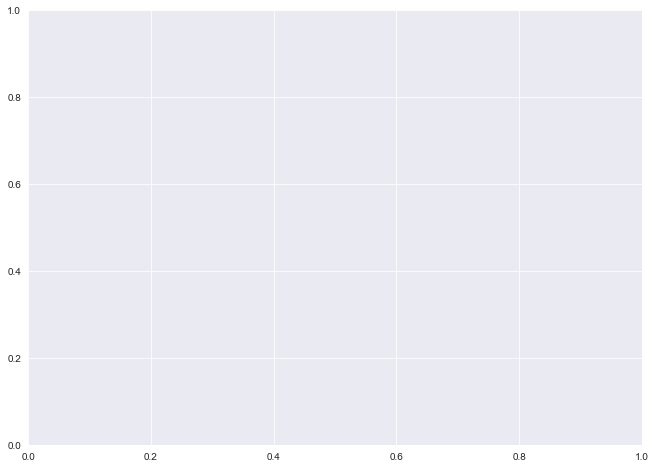

In [15]:
# Note length distribution
fig, ax = plt.subplots(figsize=(11, 8))
sns.distplot(notes_df['note_len'], kde=False, ax=ax, bins=100)
ax.set_xlim(0, 10000)
ax.set_xlabel('Length of Note (characters)')
ax.set_ylabel('# notes')

if save:
  fig.savefig(figdir/f'{cohort}_note_len_dist.pdf', dpi=300)

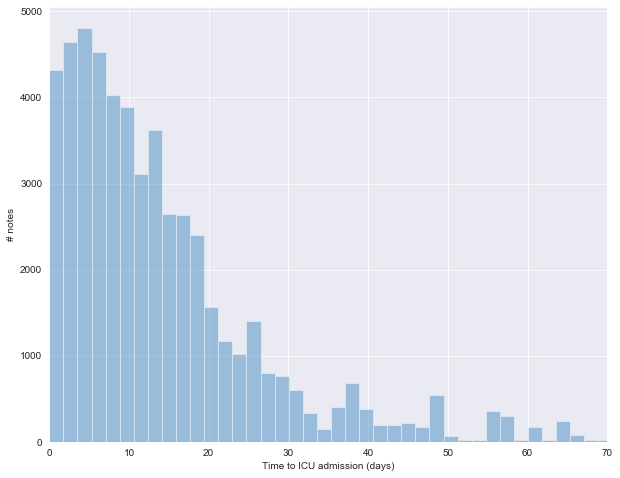

In [16]:
# Note distribution over days before ICU admission binned to 15 days
plot_df = notes_df[['admit_to_icu']]
fig, ax = plt.subplots(figsize=(10, 8))

sns.distplot(plot_df, kde=False, ax=ax, bins=80)
ax.set_xlabel('Time to ICU admission (days)')
ax.set_ylabel('# notes')
ax.set_xlim(0, 70)

if save:
  fig.savefig(figdir/f'{cohort}_admit_to_icu_dist.pdf', dpi=300)

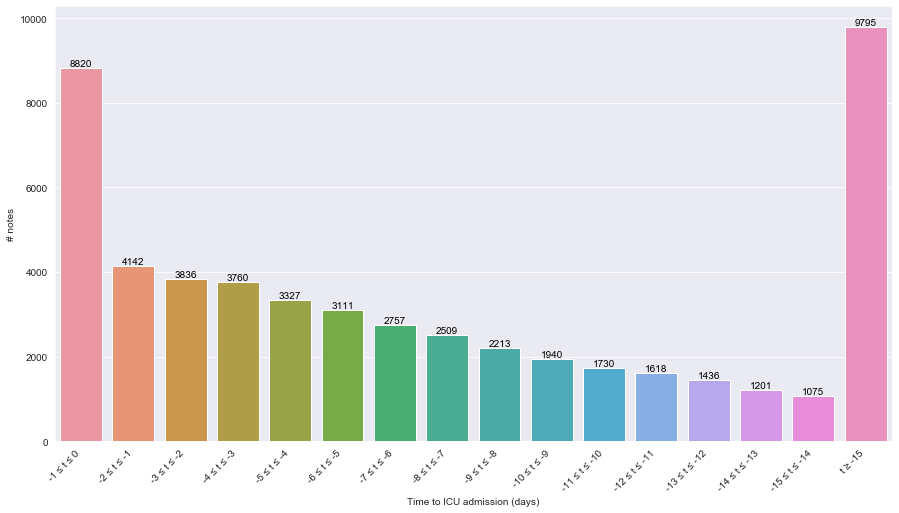

In [17]:
# Note distribution over days before ICU admission binned to 15 days
intervals = ['-1 ≤ t ≤ 0']
intervals += [f'-{i+1} ≤ t ≤ -{i}' for i in range(1, notes_df['interval'].max())]
intervals.append(f"t ≥ -{notes_df['interval'].max()}")

plot_df = pd.DataFrame(notes_df.loc[notes_df['interval'] != -1].groupby('interval').size(), columns=['n_notes']).reset_index(drop=True)
plot_df['days'] = intervals

fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(x='days', y='n_notes', data=plot_df, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')
ax.set_xlabel('Time to ICU admission (days)')
ax.set_ylabel('# notes')
for index, row in plot_df.iterrows():
    ax.text(index, row['n_notes'], str(row['n_notes']), color='black', ha='center', va='bottom')

if save:
  fig.savefig(figdir/f'{cohort}_admit_to_icu_binned_dist.pdf', dpi=300)

In [18]:
# Note distribution over days before ICU admission by Category  binned to 15 days
def plot_intervals(ax, df, cat):
  sns.barplot(x='days', y='n_notes', data=df, ax=ax)
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')
  ax.set_xlabel('')
  ax.set_ylabel('')
  ax.set_title(f"Note Category: {cat}\n# notes: {df['n_notes'].sum()}")   

  for index, (_, row) in enumerate(df.iterrows()):
      ax.text(index, row['n_notes'], str(row['n_notes']), color='black', ha='center', va='bottom') 

plot_df = pd.DataFrame(notes_df.groupby(['category', 'interval']).size(), columns=['n_notes'])
plot_df.reset_index(inplace=True)
plot_df['days'] = plot_df['interval'].apply(lambda x: intervals[x])
plot_df.drop(['interval'], inplace=True, axis=1)

fig, ax = plt.subplots(4, 3, figsize=(20, 25))
plot_intervals(ax[0][0], plot_df.loc[plot_df['category'] == 'Case Management ', ['n_notes', 'days']], 'Case Management')
plot_intervals(ax[0][1], plot_df.loc[plot_df['category'] == 'Consult', ['n_notes', 'days']], 'Consult')
plot_intervals(ax[0][2], plot_df.loc[plot_df['category'] == 'General', ['n_notes', 'days']], 'General')
               
plot_intervals(ax[1][0], plot_df.loc[plot_df['category'] == 'Nursing', ['n_notes', 'days']], 'Nursing')
plot_intervals(ax[1][1], plot_df.loc[plot_df['category'] == 'Nursing/other', ['n_notes', 'days']], 'Nursing/other')
plot_intervals(ax[1][2], plot_df.loc[plot_df['category'] == 'Nutrition', ['n_notes', 'days']], 'Nutrition')

plot_intervals(ax[2][0], plot_df.loc[plot_df['category'] == 'Pharmacy', ['n_notes', 'days']], 'Pharmacy')
plot_intervals(ax[2][1], plot_df.loc[plot_df['category'] == 'Physician ', ['n_notes', 'days',]], 'Physician')
plot_intervals(ax[2][2], plot_df.loc[plot_df['category'] == 'Radiology', ['n_notes', 'days']], 'Radiology')
               
plot_intervals(ax[3][0], plot_df.loc[plot_df['category'] == 'Rehab Services', ['n_notes', 'days']], 'Rehab Services')
plot_intervals(ax[3][1], plot_df.loc[plot_df['category'] == 'Respiratory ', ['n_notes', 'days']], 'Respiratory')
plot_intervals(ax[3][2], plot_df.loc[plot_df['category'] == 'Social Work', ['n_notes', 'days']], 'Social Work')

fig.text(0.5, 0.09, 'Time to ICU admission (days)', ha='center')
fig.text(0.08, 0.5, '# notes', va='center', rotation='vertical')

plt.subplots_adjust(hspace = 0.3)
               
if save:               
  fig.savefig(figdir/f'{cohort}_admit_to_icu_cat_binned_dist.pdf', dpi=300)

KeyError: 'category'

In [ ]:
# Histogram of time between note charttime and ICU admittime
plot_df = notes_df[['category', 'note_to_icu']]
fig, ax = plt.subplots(figsize=(10, 8))

sns.distplot(plot_df['note_to_icu'], kde=False, ax=ax, bins=80)
ax.set_xlabel('Note Charttime to ICU Admittime (days)')
ax.set_ylabel('# notes')
ax.set_xlim(0, 60)

if save:
  fig.savefig(figdir/f'{cohort}_note_to_icu_dist.pdf', dpi=300)

In [ ]:
# Histogram of time between note charttime and ICU admittime by Category
def plot_period(ax, df, cat):
  sns.distplot(df, kde=False, ax=ax, bins=10)
  ax.set_xlabel('')
  ax.set_ylabel('')
  ax.set_title(f"Note Category: {cat}")

fig, ax = plt.subplots(4, 3, figsize=(20, 25))
plot_period(ax[0][0], plot_df.loc[plot_df['category'] == 'Case Management ', ['note_to_icu']], 'Case Management')
plot_period(ax[0][1], plot_df.loc[plot_df['category'] == 'Consult', ['note_to_icu']], 'Consult')
plot_period(ax[0][2], plot_df.loc[plot_df['category'] == 'General', ['note_to_icu']], 'General')

plot_period(ax[1][0], plot_df.loc[plot_df['category'] == 'Nursing', ['note_to_icu']], 'Nursing')
plot_period(ax[1][1], plot_df.loc[plot_df['category'] == 'Nursing/other', ['note_to_icu']], 'Nursing/other')
plot_period(ax[1][2], plot_df.loc[plot_df['category'] == 'Nutrition', ['note_to_icu']], 'Nutrition')

plot_period(ax[2][0], plot_df.loc[plot_df['category'] == 'Pharmacy', ['note_to_icu']], 'Pharmacy')
plot_period(ax[2][1], plot_df.loc[plot_df['category'] == 'Physician ', ['note_to_icu',]], 'Physician')
plot_period(ax[2][2], plot_df.loc[plot_df['category'] == 'Radiology', ['note_to_icu']], 'Radiology')

plot_period(ax[3][0], plot_df.loc[plot_df['category'] == 'Rehab Services', ['note_to_icu']], 'Rehab Services')
plot_period(ax[3][1], plot_df.loc[plot_df['category'] == 'Respiratory ', ['note_to_icu']], 'Respiratory')
plot_period(ax[3][2], plot_df.loc[plot_df['category'] == 'Social Work', ['note_to_icu']], 'Social Work')

fig.text(0.5, 0.1, 'Note Charttime to ICU Admittime (days)', ha='center')
fig.text(0.08, 0.5, '# notes', va='center', rotation='vertical')

plt.subplots_adjust(hspace = 0.1)

if save:
  fig.savefig(figdir/f'{cohort}_note_to_icu_cat_dist.pdf', dpi=300)

In [ ]:
desc = ['Unused', 'Delayed ICU Admission', 'Imminent ICU Admission']

p = pd.DataFrame(notes_df.groupby(['imi_adm_label']).size(), columns=['n_notes']).reset_index()
# p1 = pd.DataFrame(notes_df.groupby(['imi_adm_label']).size(), columns=['n_notes']).reset_index()
# p2 = notes_df.groupby(['imi_adm_label'])['hadm_id'].nunique().reset_index()

# p = p1.merge(p2, on=['imi_adm_label'])
p['imi_adm_label'] = desc
p = p.reindex([2, 1, 0])
# p.reset_index(inplace=True, drop=True)

plot_df = p.copy()
plot_df.rename(columns={'hadm_id':'# Encounters', 'n_notes':'# Notes'}, inplace=True)
plot_df = pd.melt(plot_df, id_vars='imi_adm_label', var_name='Legend', value_name='counts')

plot_df

fig, ax = plt.subplots(figsize=(11, 8))
sns.barplot(x='imi_adm_label', y='counts', data=plot_df, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), ha='center')
ax.set_xlabel('Class Label')
ax.set_ylabel('# notes')

for index, row in plot_df.iterrows():
#     if index < len(plot_df)//2:
        ax.text(index+0.06, row['counts'], str(row['counts']), color='black', ha='right', va='bottom')
#     else:
#         ax.text(index % (len(plot_df)//2), row['counts'], str(row['counts']), color='black', ha='right', va='bottom')

if save:
  fig.savefig(figdir/f'{cohort}_note_class_dist.pdf', dpi=300)